In [1]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import os
import random
from collections import Counter

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
from nltk.tokenize import word_tokenize


from torch.utils.data import Dataset
import os
from PIL import Image
import nltk
from torchvision import transforms
from collections import Counter
from nltk.tokenize import word_tokenize
import torch
from torch.nn.functional import pad

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bardi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#@title  Hyperparameters

batch_size = 1              # Number of samples processed at once
caption_length = 10         # Length of dummy/test captions
vocab_size = 5000           # Simulated vocabulary size (real vocab will come in Task 3)
embed_size = 256            # Embedding dimension for words
hidden_size = 512           # LSTM hidden state size
num_layers = 1              # Number of LSTM layers


In [3]:
#@title 3. Define Image Encoder (CNN)

class ImageEncoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]  # remove last fc and avgpool
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        
        for param in self.resnet.parameters():  #  fixed typo here
            param.requires_grad = False  # freeze pretrained CNN

    def forward(self, images):
        features = self.resnet(images)             # (batch_size, 2048, H/32, W/32)
        features = self.adaptive_pool(features)    # (batch_size, 2048, 14, 14)
        features = features.permute(0, 2, 3, 1)     # (batch_size, 14, 14, 2048)
        return features


In [4]:
#@title 4. Image Preprocessing Function

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # (1, 3, 256, 256)
    return image

# Load and encode a sample image (r
image_tensor = load_image(r"G:/Documents/school/advanced ai 2025/lab3 data/Images/2186139563_e60c1d4b8b.jpg")
encoder = ImageEncoder()

with torch.no_grad():
    image_features = encoder(image_tensor)

print("Image feature shape:", image_features.shape)


c:\Users\bardi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bardi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image feature shape: torch.Size([1, 14, 14, 2048])


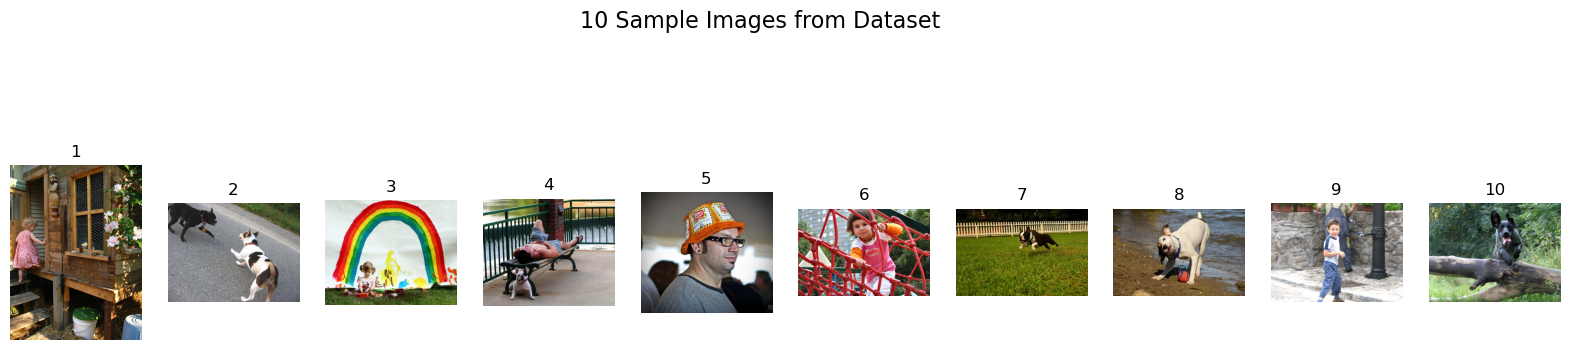

In [6]:
#@title 5. Show 10 Original Images (Preview as Grid)
import matplotlib.pyplot as plt
import os
from PIL import Image

# Folder where your dataset is stored
image_folder = r"G:\Documents\school\advanced ai 2025\lab3 data\Images"

# Get first 10 JPEG images in the folder
all_images = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
sample_images = all_images[:10]  # pick first 10 (or use random.sample for randomness)

# Plot them in a horizontal row
plt.figure(figsize=(20, 5))

for i, image_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, image_name)
    image = Image.open(img_path).convert('RGB')
    plt.subplot(1, 10, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{i+1}")

plt.suptitle("10 Sample Images from Dataset", fontsize=16)
plt.show()


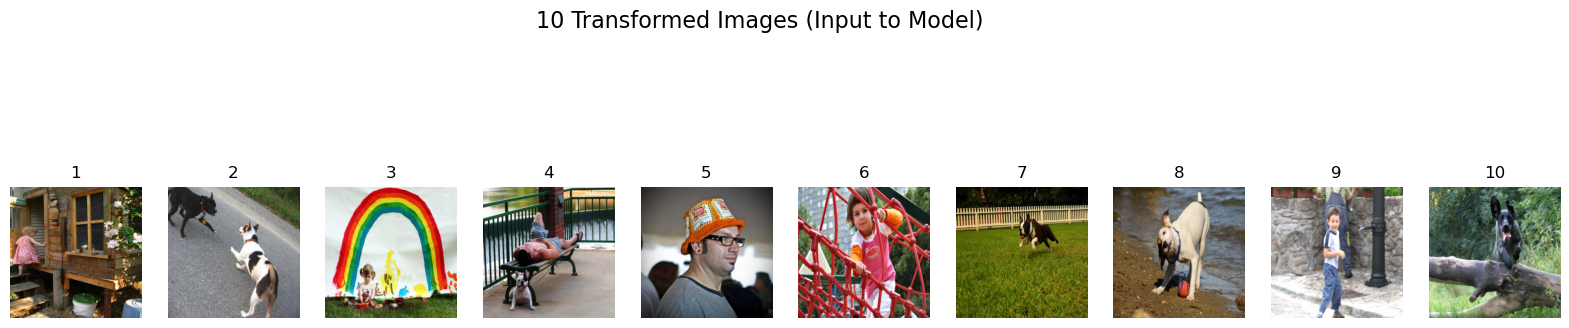

In [7]:
#@title 6. Show 10 Transformed Images (Post-Processing)

def show_transformed_images(image_folder, image_names, transform):
    plt.figure(figsize=(20, 5))

    for i, image_name in enumerate(image_names):
        img_path = os.path.join(image_folder, image_name)
        image = Image.open(img_path).convert('RGB')
        transformed = transform(image).unsqueeze(0)  # add batch dimension

        # Undo normalization for display
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        transformed = transformed.squeeze(0)  # remove batch dimension
        transformed = transformed * std[:, None, None] + mean[:, None, None]
        transformed = transformed.clamp(0, 1)

        np_image = transformed.permute(1, 2, 0).numpy()

        plt.subplot(1, 10, i + 1)
        plt.imshow(np_image)
        plt.axis('off')
        plt.title(f"{i+1}")

    plt.suptitle("10 Transformed Images (Input to Model)", fontsize=16)
    plt.show()

# Reuse the folder and image list from step 5
show_transformed_images(image_folder, sample_images, transform)


In [11]:
#@title 8. Test Decoder with Dummy Caption Input
# Decoder Test (Structure Only)

"""
We're only testing the decoder model here — not generating actual captions yet.

- Creates random word indices to simulate a caption (dummy input)
- Passes them through the decoder with image features
- Output is a `(10, 5000)` tensor of raw prediction scores (not human-readable words)
- Actual caption generation happens after training, during inference
"""

# Define dummy parameters
batch_size = 1
vocab_size = 5000       # 🔁 pretend you have 5000 words in your vocabulary
embed_size = 256        # 📐 each word is represented by a 256-dim vector
hidden_size = 512       # 🧠 LSTM hidden state size
caption_length = 10     # 📝 pretend the caption is 10 words long

# Create dummy caption tokens: shape = (batch_size, caption_length)
dummy_captions = torch.randint(0, vocab_size, (batch_size, caption_length))

# Simulate caption length list (used by pack_padded_sequence)
dummy_lengths = [caption_length]

# Initialize the decoder
decoder = CaptionDecoder(embed_size, hidden_size, vocab_size, num_layers)

# Forward pass through the decoder
outputs = decoder(dummy_captions, image_features, dummy_lengths)

# Output shape should be (total_words, vocab_size) = (10, 5000)
print("Decoder output shape:", outputs.shape)


Decoder output shape: torch.Size([10, 5000])


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class EncodedImagesDataset(Dataset):
    """
    Dataset that loads pre-encoded image features.

    Args:
        encoded_features_path (str): Path to a directory or file containing
                                     the encoded image features. The format
                                     is flexible and handled by the load_features_fn.
        image_paths (list): A list of the original image file paths, used for
                            mapping or other purposes if needed.
        load_features_fn (callable): A function that takes an image path
                                      (or a processed version) and returns
                                      the corresponding encoded feature tensor.
    """
    def __init__(self, encoded_features_path, image_paths, load_features_fn):
        self.encoded_features_path = encoded_features_path
        self.image_paths = image_paths
        self.load_features = load_features_fn

        # You might need to adjust how you store and access encoded features
        # based on how you saved them. This example assumes a direct mapping
        # between the order of image paths and the availability of encoded features.
        # A more robust approach might involve saving encoded features with
        # a filename or identifier that links back to the original image.

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        encoded_features = self.load_features(image_path)
        return encoded_features, image_path # You might want to include the path or index

# --- How to use this DataLoader with the encoding process from your code ---

# 1. Initialize the ImageEncoder
encoder = ImageEncoder()
encoder.eval() # Set to evaluation mode

# 2. Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# 3. Specify the folder containing your images
image_folder = r"G:\Documents\school\advanced ai 2025\lab3 data\Images"
all_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]

# 4. Function to load and encode a single image
def encode_single_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = encoder(image)
    return features.squeeze(0) # Remove the batch dimension for a single image

# 5. (Optional but Recommended) Pre-encode all images and save the features
#    This avoids re-encoding during each epoch of training the decoder.
encoded_features_list = []
for img_path in all_images:
    encoded_features = encode_single_image(img_path)
    encoded_features_list.append(encoded_features)

# Now, you need to decide how to store these encoded features.
# You could:
#   - Save them to a single file (e.g., a pickled list of tensors).
#   - Save each encoded feature to a separate file, named after the original image.

# Example of saving to a single file (replace with your desired method):
encoded_features_save_path = "encoded_image_features.pth"
torch.save(encoded_features_list, encoded_features_save_path)

# 6. Create a function to load the pre-encoded features
def load_pre_encoded_features(image_path):
    # This function needs to know how your encoded features are stored
    # and retrieve the correct feature tensor based on the image_path.

    # Example if you saved to a single list:
    all_encoded_features = torch.load(encoded_features_save_path)
    try:
        index = all_images.index(image_path)
        return all_encoded_features[index]
    except ValueError:
        print(f"Warning: Image path '{image_path}' not found in the list.")
        return None

# 7. Instantiate the EncodedImagesDataset
encoded_dataset = EncodedImagesDataset(
    encoded_features_path=".", # The loading function handles the path
    image_paths=all_images,
    load_features_fn=load_pre_encoded_features
)

# 8. Create the DataLoader
encoded_dataloader = DataLoader(encoded_dataset, batch_size=32, shuffle=True)

# --- Now you can iterate through the encoded_dataloader ---
if __name__ == '__main__':
    for encoded_features, original_paths in encoded_dataloader:
        print("Encoded features batch shape:", encoded_features.shape)
        print("Original image paths in batch:", original_paths)
        # You can now use 'encoded_features' as input to your caption decoder
        break

c:\Users\bardi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bardi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoded features batch shape: torch.Size([32, 14, 14, 2048])
Original image paths in batch: ('G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\3681575323_433d007650.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\2053441349_a98b5fc742.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\3629664676_36bcefe6b7.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\3183883750_b6acc40397.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\2834752476_3177e617f1.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\2479652566_8f9fac8af5.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\2507182524_7e83c6de82.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\1096395242_fc69f0ae5a.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\3047749814_621ed0786b.jpg', 'G:\\Documents\\school\\advanced ai 2025\\lab3 data\\Images\\2921112724_5cb85d7413.jpg', 'G:\\Documents\\s

In [24]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):  # Initialize the class
        super(DecoderWithAttention, self).__init__()  # Call the parent class's constructor
        self.encoder_dim = encoder_dim  # Set the encoder dimension
        self.attention_dim = attention_dim  # Set the attention dimension
        self.embed_dim = embed_dim  # Set the embedding dimension
        self.decoder_dim = decoder_dim  # Set the decoder dimension
        self.vocab_size = vocab_size  # Set the vocabulary size
        self.dropout = dropout  # Set the dropout rate

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # Initialize the Attention layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Define the embedding layer
        self.dropout = nn.Dropout(p=self.dropout)  # Define the dropout layer
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # Define the LSTM cell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # Linear layer to initialize hidden state
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # Linear layer to initialize cell state
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # Linear layer to create a gate
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function
        self.fc = nn.Linear(decoder_dim, vocab_size)  # Fully connected layer to predict the next word
        self.init_weights()  # Initialize the weights

    def init_weights(self):  # Method to initialize weights
        self.embedding.weight.data.uniform_(-0.1, 0.1)  # Initialize embedding weights
        self.fc.bias.data.fill_(0)  # Initialize fully connected layer bias
        self.fc.weight.data.uniform_(-0.1, 0.1)  # Initialize fully connected layer weights
        
    def load_pretrained_embeddings(self, embeddings):  # Method to load pretrained embeddings
        self.embedding.weight = nn.Parameter(embeddings)  # Set the embedding weights to the pretrained embeddings

    def fine_tune_embeddings(self, fine_tune=True):  # Method to allow fine-tuning of embeddings
        for p in self.embedding.parameters():  # Iterate over all embedding parameters
            p.requires_grad = fine_tune  # Set requires_grad based on the fine_tune argument

    def init_hidden_state(self, encoder_out):  # Method to initialize hidden states
        mean_encoder_out = encoder_out.mean(dim=1)  # Compute the mean of the encoder output
        h = self.init_h(mean_encoder_out)  # Initialize hidden state
        c = self.init_c(mean_encoder_out)  # Initialize cell state
        return h, c  # Return hidden and cell states

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)  # Get the batch size
        encoder_dim = encoder_out.size(-1)  # Get the encoder dimension
        vocab_size = self.vocab_size  # Get the vocabulary size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # Reshape encoder output
        num_pixels = encoder_out.size(1)  # Get the number of pixels

        # Sort input data by decreasing lengths
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)  # Sort caption lengths and get sort indices
        encoder_out = encoder_out[sort_ind]  # Reorder encoder output
        encoded_captions = encoded_captions[sort_ind]  # Reorder encoded captions

        embeddings = self.embedding(encoded_captions)  # Embed the encoded captions

        h, c = self.init_hidden_state(encoder_out)  # Initialize hidden states

        decode_lengths = (caption_lengths - 1).tolist()

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels)
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t], h[:batch_size_t]
            )  # Get attention weighted encoding and alphas
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # Compute the gate value
            attention_weighted_encoding = gate * attention_weighted_encoding  # Apply the gate

            # COMBINING IMAGE AND TEXT DATA HAPPENS HERE:
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]),
            )  # Update hidden and cell states
            preds = self.fc(self.dropout(h))  # Compute predictions
            predictions[:batch_size_t, t, :] = preds  # Store predictions
            alphas[:batch_size_t, t, :] = alpha  # Store alphas

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind


In [27]:
# Import necessary libraries for visualization, image processing, and deep learning
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.models as models
import torch.nn as nn
import random

def save_model(epoch, encoder, decoder, optimizer, val_loss, filename):
    """
    Save the model checkpoint to disk.
    
    Args:
        epoch (int): Current epoch number
        encoder (nn.Module): The encoder model
        decoder (nn.Module): The decoder model with attention
        optimizer (torch.optim): The optimizer
        val_loss (float): Validation loss value
        filename (str): Path to save the checkpoint
    """
    torch.save({
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }, filename)

# Set up device for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters for the model
embed_size = 512        # Dimension of word embeddings
attention_dim = 512     # Dimension of attention linear layers
hidden_size = 512       # Dimension of decoder RNN hidden state
#vocab_size = len(Dataset.vocab)  # Size of vocabulary
num_layers = 1          # Number of layers in LSTM
dropout = 0.5           # Dropout probability
encoder_dim = 2048      # Feature size of encoded images
learning_rate = 0.001   # Learning rate for optimizer
num_epochs = 10         # Number of training epochs

# Initialize the encoder (CNN) and decoder (LSTM with attention) models
# and move them to the appropriate device
encoder = Encoder().to(device)
decoder = DecoderWithAttention(attention_dim, embed_size, hidden_size, 
                               vocab_size, encoder_dim, dropout).to(device)

# Define loss function (ignoring padding tokens) and optimizer
# PAD tokens are ignored in loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
# Optimize parameters of both encoder and decoder
optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.parameters()), 
                             lr=learning_rate)

def evaluate_model(loader, encoder, decoder, criterion):
    """
    Evaluate the model on a data loader.
    
    Args:
        loader (DataLoader): DataLoader for evaluation
        encoder (nn.Module): The encoder model
        decoder (nn.Module): The decoder model with attention
        criterion (nn.Module): The loss function
        
    Returns:
        float: Average loss over the dataset
    """
    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()
    total_loss = 0
    
    # Disable gradient calculation during evaluation
    with torch.no_grad():
        for images, captions, lengths in loader:
            # Move data to device
            images, captions = images.to(device), captions.to(device)
            
            # Sort input data by decreasing lengths
            # This is needed for packed sequence processing
            lengths, sort_ind = lengths.sort(dim=0, descending=True)
            images, captions = images[sort_ind], captions[sort_ind]

            # Forward pass through encoder
            features = encoder(images)
            
            # Forward pass through decoder with attention
            outputs, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths)

            # Since we're predicting the next word, targets are captions shifted by one
            targets = caps_sorted[:, 1:]

            # Pack outputs and targets to handle variable length sequences properly
            outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # Calculate loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
    # Return average loss
    return total_loss / len(loader)

# Training loop
for epoch in range(num_epochs):
    # Set models to training mode
    encoder.train()
    decoder.train()
    
    # Iterate through batches
    for i, (images, captions, lengths) in enumerate(train_loader):
        # Move data to device
        images, captions = images.to(device), captions.to(device)
        
        # Sort input data by decreasing lengths for packed sequence processing
        lengths, sort_ind = lengths.sort(dim=0, descending=True)
        images, captions = images[sort_ind], captions[sort_ind]

        # Clear previous gradients
        optimizer.zero_grad()
        
        # Forward pass through encoder to get image features
        features = encoder(images)
        
        # Forward pass through decoder with attention
        outputs, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths)

        # Set up targets (caption shifted by one position)
        targets = caps_sorted[:, 1:]

        # Pack outputs and targets to handle variable length sequences
        outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print progress every 100 batches
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Validation phase at the end of each epoch
    val_loss = evaluate_model(val_loader, encoder, decoder, criterion)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {val_loss:.4f}')

    # Save model checkpoint after each epoch
    save_model(epoch, encoder, decoder, optimizer, val_loss, 
               f'model_epoch_{epoch+1}_valloss_{val_loss:.4f}.pth')

# Final evaluation on test set
test_loss = evaluate_model(test_loader, encoder, decoder, criterion)
print(f'Test Loss: {test_loss:.4f}')

print('Finished Training')

NameError: name 'Encoder' is not defined

In [ ]:
# Import necessary libraries for visualization, image processing, and deep learning
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.models as models
import torch.nn as nn
import random

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_checkpoint(filepath):
    """
    Load a previously saved model checkpoint.
    
    Args:
        filepath (str): Path to the checkpoint file
        
    Returns:
        tuple: The loaded encoder and decoder models
    """
    # Load the saved model state
    checkpoint = torch.load(filepath)
    
    # Define model parameters - these should match what was used during training
    attention_dim = 512  # Dimension of attention mechanism
    embed_size = 512     # Dimension of word embeddings
    hidden_size = 512    # Dimension of LSTM hidden state
    vocab_size = len(dataset.vocab)  # Size of vocabulary
    encoder_dim = 2048   # Dimension of encoder output features
    dropout = 0.5        # Dropout rate for regularization
    
    # Initialize the encoder and decoder models
    encoder = Encoder()
    decoder = DecoderWithAttention(
        attention_dim=attention_dim,
        embed_dim=embed_size,
        decoder_dim=hidden_size,
        vocab_size=vocab_size,
        encoder_dim=encoder_dim,
        dropout=dropout
    )
    
    # Load the saved state dictionaries into the models
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
    return encoder, decoder

def generate_caption(image, encoder, decoder, vocab, transform):
    """
    Generate a caption for an input image using the trained encoder-decoder model.
    
    Args:
        image (PIL.Image): Input image to caption
        encoder (nn.Module): The encoder model
        decoder (nn.Module): The decoder model with attention
        vocab (dict): Vocabulary mapping words to indices
        transform (transforms): Image transformations to apply
        
    Returns:
        str: Generated caption for the image
    """
    # Preprocess the image and move it to the device
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    with torch.no_grad():  # No need to track gradients during inference
        # Extract image features using the encoder
        features = encoder(image)
        features = features.view(1, -1, features.size(-1))  # Reshape features for attention
        
        # Initialize LSTM hidden and cell states
        h, c = decoder.init_hidden_state(features)

        # Start token to begin the caption generation
        start_token = torch.tensor([vocab['<START>']]).unsqueeze(0).to(device)
        inputs = start_token

        caption = []
        # Generate caption word by word until max length or <END> token
        for _ in range(dataset.max_length):
            # Get word embeddings
            embeddings = decoder.embedding(inputs).squeeze(1)
            
            # Compute attention weights and context vector
            attention_weighted_encoding, alpha = decoder.attention(features, h)
            
            # Apply adaptive attention gate
            gate = decoder.sigmoid(decoder.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # LSTM decoder step
            h, c = decoder.decode_step(
                torch.cat([embeddings, attention_weighted_encoding.squeeze(1)], dim=1),
                (h, c)
            )
            
            # Project LSTM outputs to vocabulary space
            output = decoder.fc(h)
            
            # Select word with highest probability
            _, predicted = output.max(1)
            inputs = predicted.unsqueeze(0)  # Prepare for next iteration

            # Convert index to word and add to caption
            word = dataset.index_to_word[predicted.item()]
            if word == '<END>':
                break  # Stop if END token is generated
            caption.append(word)

    # Join the words to form the complete caption
    return ' '.join(caption)

def show_image_with_captions(image, original_caption, generated_caption):
    """
    Display the image along with original and generated captions.
    
    Args:
        image (PIL.Image): The image to display
        original_caption (str): The ground truth caption
        generated_caption (str): The model-generated caption
    """
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Original Caption: {original_caption}\nGenerated Caption: {generated_caption}")
    plt.show()

# Load the trained model from checkpoint
encoder, decoder = load_checkpoint('model_epoch_10_valloss_2.8538.pth')
encoder = encoder.to(device)  # Move models to GPU/CPU
decoder = decoder.to(device)

# Select a random sample from the validation dataset to test caption generation
random_idx = random.randint(0, len(dataset) - 1)
image_path = dataset.img_paths[random_idx]
original_caption = original_captions[random_idx]  # Get the ground truth caption

# Load and convert the image to RGB format
image = Image.open(image_path).convert("RGB")

# Generate a caption for the image using our model
generated_caption = generate_caption(image, encoder, decoder, dataset.vocab, transform)

# Display the image with both the original and generated captions
show_image_with_captions(image, original_caption, generated_caption)